In [1]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:00<00:00, 223MB/s]
100% 149M/149M [00:00<00:00, 203MB/s]


In [2]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [37]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
import seaborn as sns

In [4]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Collect the file paths and assign corresponding labels to the dataset.
# 'folds' represent different classes (e.g., tumor types) in the training data directory.
# For each class, iterate through all image files, append the full file path to 'filepaths',
# and assign the folder name (representing the class label) to 'labels'.
# This creates a structured list of image file paths with their associated labels.

train_data_dir = '/content/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

In [6]:
# 'Fseries' holds the image file paths, and 'Lseries' holds the corresponding labels (class names).
# Concatenate to a pandas dataframe 'train_df'
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
# Dataframe Output
train_df

,filepaths,labels
0,/content/Training/glioma/Tr-gl_0113.jpg,glioma
1,/content/Training/glioma/Tr-gl_1027.jpg,glioma
2,/content/Training/glioma/Tr-gl_0686.jpg,glioma
3,/content/Training/glioma/Tr-gl_1143.jpg,glioma
4,/content/Training/glioma/Tr-gl_1111.jpg,glioma
...,...,...
5707,/content/Training/notumor/Tr-no_0509.jpg,notumor
5708,/content/Training/notumor/Tr-noTr_0002.jpg,notumor
5709,/content/Training/notumor/Tr-no_0937.jpg,notumor
5710,/content/Training/notumor/Tr-no_0850.jpg,notumor


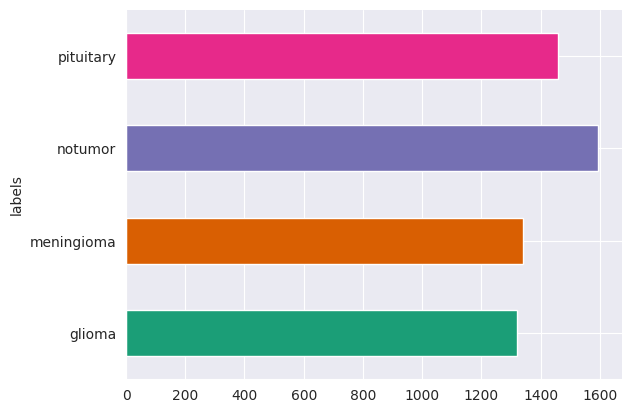

In [8]:
#  Visualize the distribution of the dataset by plotting the count of each class label.

train_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
# Collect the file paths and assign labels for the test dataset.
# 'test_data_dir' is the directory containing the test data organized into sub-folders by class labels.
test_data_dir = '/content/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

In [10]:
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

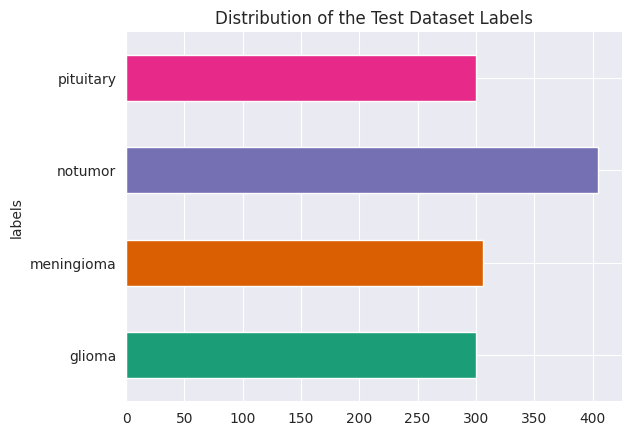

In [11]:
# Display the first few rows of the test dataset
ts_df.head()

# Visulize the distribution of dataset
ts_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title("Distribution of the Test Dataset Labels")
plt.show()

In [12]:
# Split test data into 50% validation and 50% test to maximize training data for the deep learning model.
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=123)


In [13]:
# Define input shape and batch size to prepare 224x224 RGB images for training, crucial for feeding consistent-sized data into the neural network.
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


In [14]:
# Initialize data generators for real-time data augmentation (tr_gen for training and ts_gen for testing/validation)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [15]:
# Create a training data generator that reads images and labels from the 'train_df' dataframe.
# It resizes images to the target size, shuffles the data, and returns batches of images and labels in categorical format for training.
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


Found 5712 validated image filenames belonging to 4 classes.


In [16]:
# Create data generator for validation data to batch, resize and shuffle
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

Found 655 validated image filenames belonging to 4 classes.


In [17]:
# Create data generator that reads images and labels from test_df, resizes them, and batches them without shuffling for testing or evaluation.
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 656 validated image filenames belonging to 4 classes.


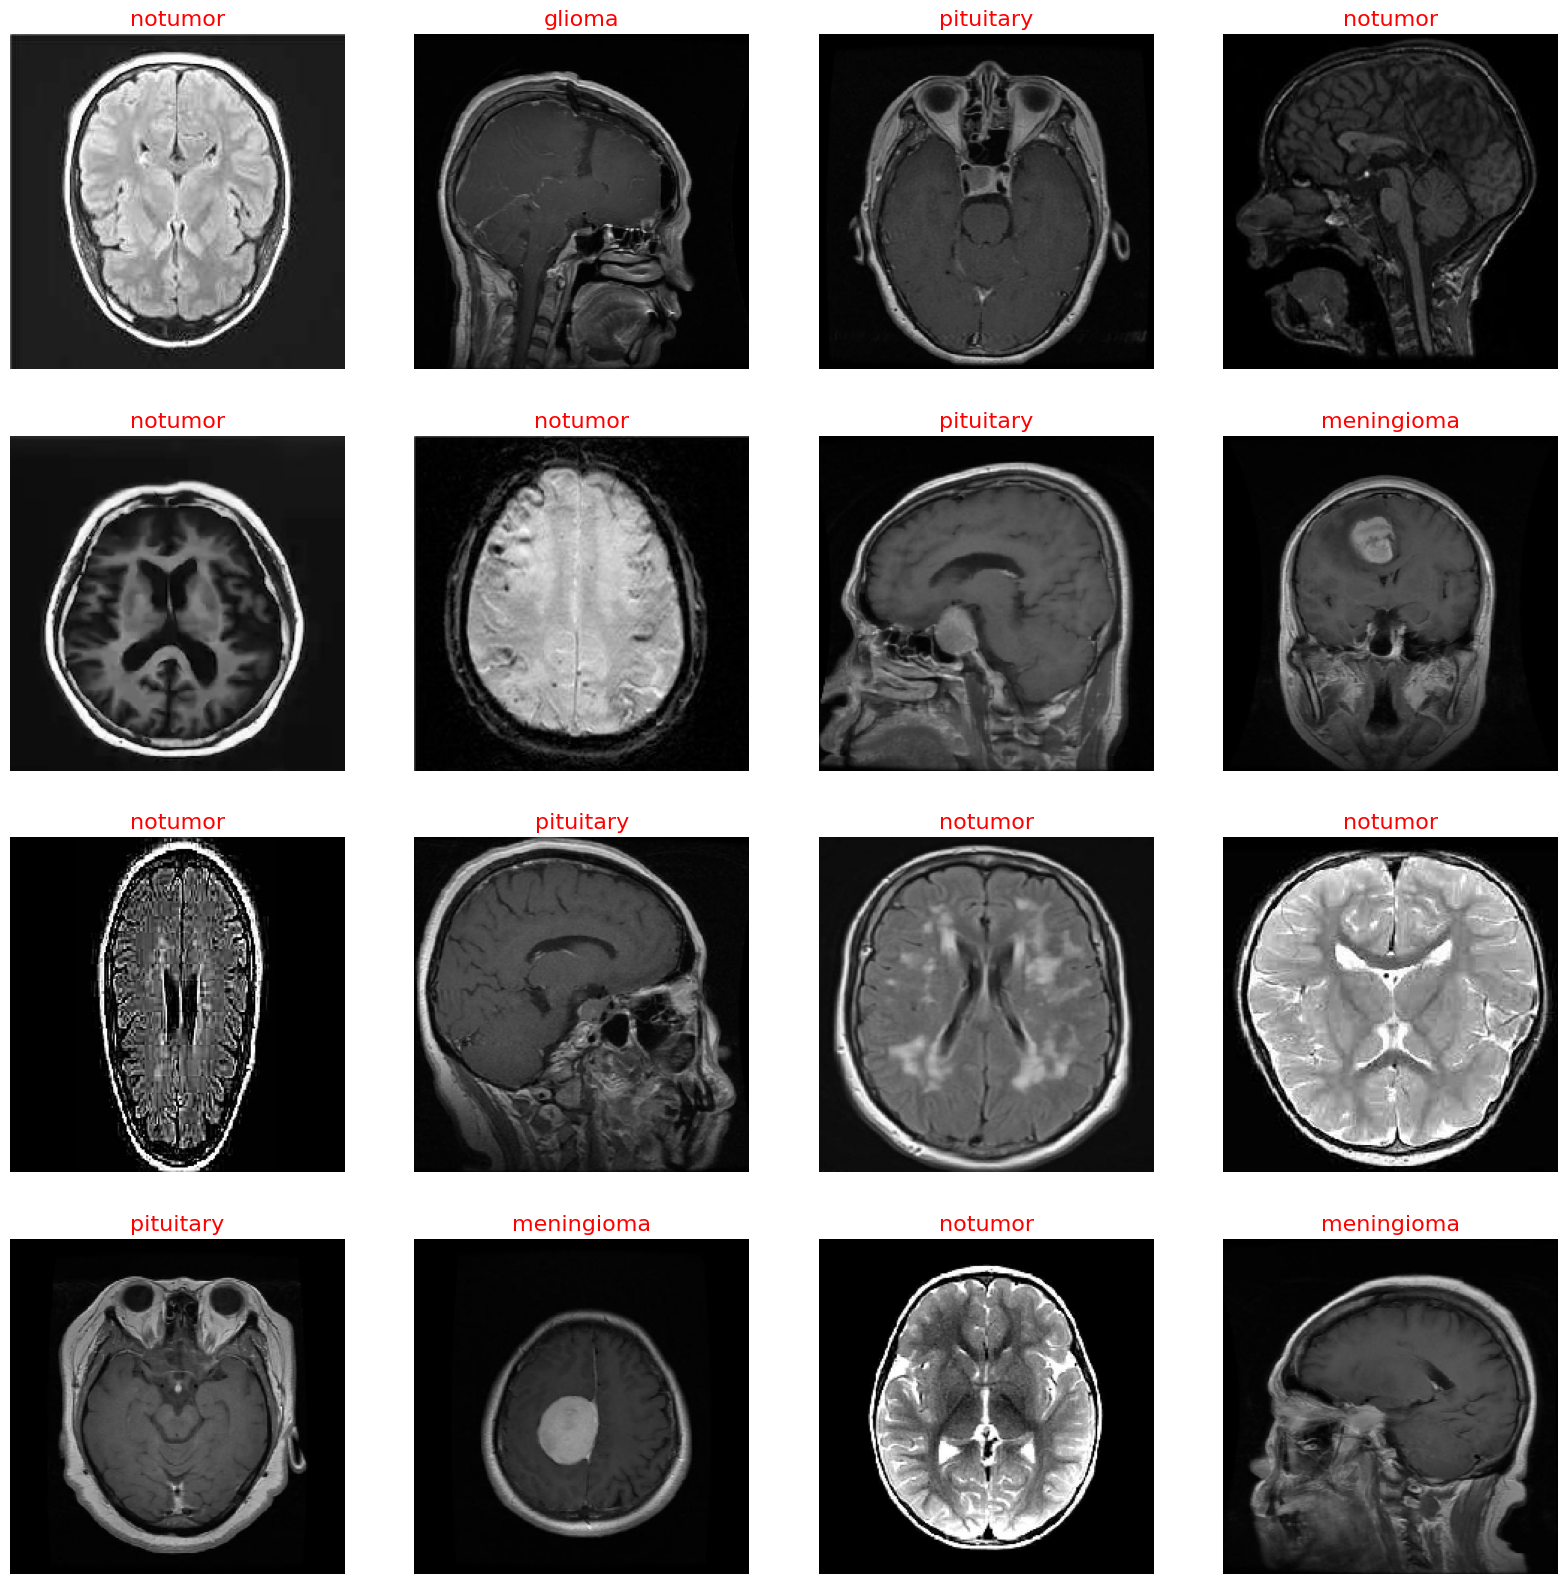

In [18]:
# Visualize the first 16 images along with their labels from train_gen.
tum_image = train_gen.class_indices
classes = list(tum_image.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))


for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # Normalize image for display
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='red', fontsize=16)
    plt.axis('off')

plt.show()


In [19]:
# Load the VGG16 model pre-trained on ImageNet, excluding the top classification layers.
vgg = VGG16(include_top=False, input_shape=img_shape, pooling='avg')


# vgg = VGG16(include_top=False, input_shape=img_shape, pooling='max')
# resnet = ResNet50(include_top=False, input_shape=img_shape, pooling='avg')
# inception = InceptionV3(include_top=False, input_shape=img_shape, pooling='avg')

58889256/58889256 [==============================] - 0s 0us/step


In [20]:
def extract_features(generator, model):
    features = []
    labels = []
    for i, (img, label) in enumerate(generator):
        feature = model.predict(img)
        features.append(feature)
        labels.append(label)
        if i == len(generator) - 1:
            break
    features = np.vstack(features)
    labels = np.argmax(np.vstack(labels), axis=1)
    return features, labels

In [21]:
# extract features for training, validation, and testing datasets
train_features, train_labels = extract_features(train_gen, vgg)
valid_features, valid_labels = extract_features(valid_gen, vgg)
test_features, test_labels = extract_features(test_gen, vgg)

1/1 [==============================] - 0s 323ms/step


In [22]:
# encode labels for KNN and SVM
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
valid_labels_enc = le.transform(valid_labels)
test_labels_enc = le.transform(test_labels)

In [23]:
# train KNN model
# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(train_features, train_labels_enc)
# knn_pred = knn.predict(test_features)
# knn_accuracy = accuracy_score(test_labels_enc, knn_pred)

# 5-fold cross initilization
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation for KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn_cv_scores = cross_val_score(knn, train_features, train_labels_enc, cv=cv, scoring='accuracy')

print("KNN Model 5-Fold CV Accuracies for each fold:")
for i, score in enumerate(knn_cv_scores):
    print(f"Fold {i+1}: {score:.2f}")

# Print the KNN cross-validation results
print(f"KNN Model 5-Fold CV Accuracy: {knn_cv_scores.mean():.2f} (+/- {knn_cv_scores.std() * 2:.2f})")


KNN Model 5-Fold CV Accuracies for each fold:
Fold 1: 0.93
Fold 2: 0.92
Fold 3: 0.92
Fold 4: 0.93
Fold 5: 0.93
KNN Model 5-Fold CV Accuracy: 0.93 (+/- 0.01)


In [24]:
# train SVM model
# svm = SVC(kernel='linear', probability=True)
# svm.fit(train_features, train_labels_enc)
# svm_pred = svm.predict(test_features)
# svm_accuracy = accuracy_score(test_labels_enc, svm_pred)


# Perform Cross-Validation for SVM
svm = SVC(kernel='linear', probability=True)
svm_cv_scores = cross_val_score(svm, train_features, train_labels_enc, cv=cv, scoring='accuracy')

# Print the SVM cross-validation results
print(f"SVM Model 5-Fold CV Accuracy: {svm_cv_scores.mean():.2f} (+/- {svm_cv_scores.std() * 2:.2f})")

SVM Model 5-Fold CV Accuracy: 0.92 (+/- 0.02)


In [25]:
# Train KNN on the full training data after cross-validation
knn.fit(train_features, train_labels_enc)

# Evaluate KNN on the validation set
valid_accuracy_knn = knn.score(valid_features, valid_labels_enc)
print(f"KNN Model Validation Set Accuracy: {valid_accuracy_knn:.2f}")

# Evaluate KNN on the test set
# test_accuracy_knn = knn.score(test_features, test_labels_enc)
# print(f"KNN Model Test Set Accuracy: {test_accuracy_knn:.2f}")

KNN Model Validation Set Accuracy: 0.94


In [26]:
# After cross-validation, train the SVM model on the full training set
svm.fit(train_features, train_labels_enc)

# Evaluate on the validation set
valid_accuracy = svm.score(valid_features, valid_labels_enc)
print(f"SVM Model Validation Set Accuracy: {valid_accuracy:.2f}")

# Finally, evaluate on the test set
# test_accuracy = svm.score(test_features, test_labels_enc)
# print(f"SVM Model Test Set Accuracy: {test_accuracy:.2f}")


SVM Model Validation Set Accuracy: 0.95


In [27]:
# build CNN model
img_shape = (224, 224, 3)
class_count = 4
cnn_model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=img_shape),
    Conv2D(64, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, kernel_size=(3,3), activation="relu"),
    Conv2D(128, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(256, kernel_size=(3,3), activation="relu"),
    Conv2D(256, kernel_size=(3,3), activation="relu"),
    Conv2D(256, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    Conv2D(512, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(class_count, activation="softmax")
])

In [28]:
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                   

In [29]:
# train CNN model
epochs = 10
history = cnn_model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
357/357 [==============================] - 707s 2s/step - loss: 1.1419 - accuracy: 0.5632 - val_loss: 0.6998 - val_accuracy: 0.7084
Epoch 2/10
357/357 [==============================] - 705s 2s/step - loss: 0.6189 - accuracy: 0.7600 - val_loss: 0.7242 - val_accuracy: 0.7115
Epoch 3/10
357/357 [==============================] - 703s 2s/step - loss: 0.4795 - accuracy: 0.8227 - val_loss: 0.5977 - val_accuracy: 0.7710
Epoch 4/10
357/357 [==============================] - 702s 2s/step - loss: 0.3667 - accuracy: 0.8603 - val_loss: 0.4387 - val_accuracy: 0.8092
Epoch 5/10
357/357 [==============================] - 701s 2s/step - loss: 0.3183 - accuracy: 0.8843 - val_loss: 0.3457 - val_accuracy: 0.8733
Epoch 6/10
357/357 [==============================] - 701s 2s/step - loss: 0.2499 - accuracy: 0.9065 - val_loss: 0.3253 - val_accuracy: 0.8870
Epoch 7/10
357/357 [==============================] - 698s 2s/step - loss: 0.2026 - accuracy: 0.9286 - val_loss: 0.2772 - val_accuracy: 0.8947

In [30]:
# save model to use as feature extractor
cnn_model.save('cnn_model.h5')

In [31]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [32]:
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

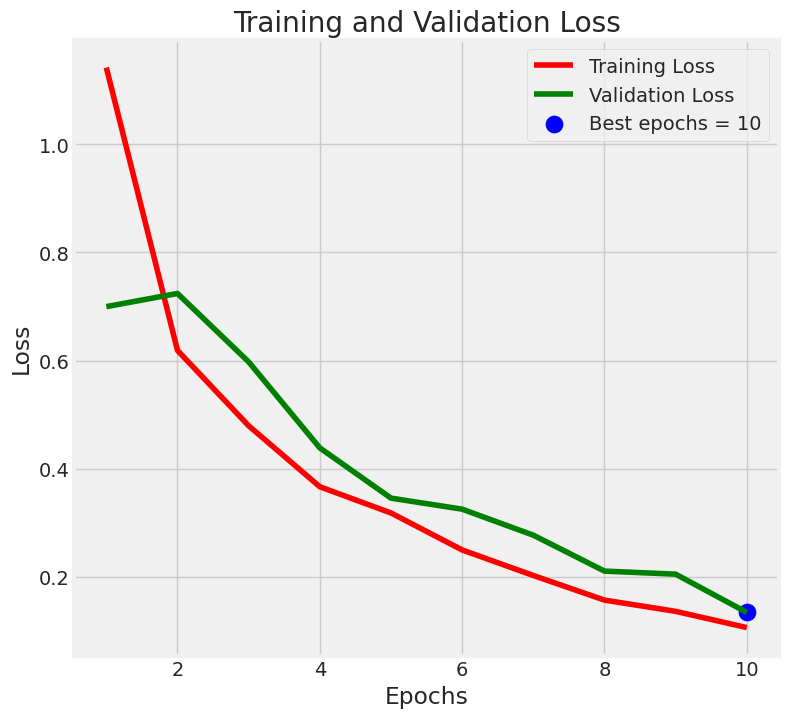

In [33]:
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Learning Curve: Evaluates performance as a function of training size (how much training data is used).
Error Graph (Validation Curve): Evaluates performance (or error rate) as a function of a hyperparameter (e.g., number of neighbors in KNN, regularization C in SVM).

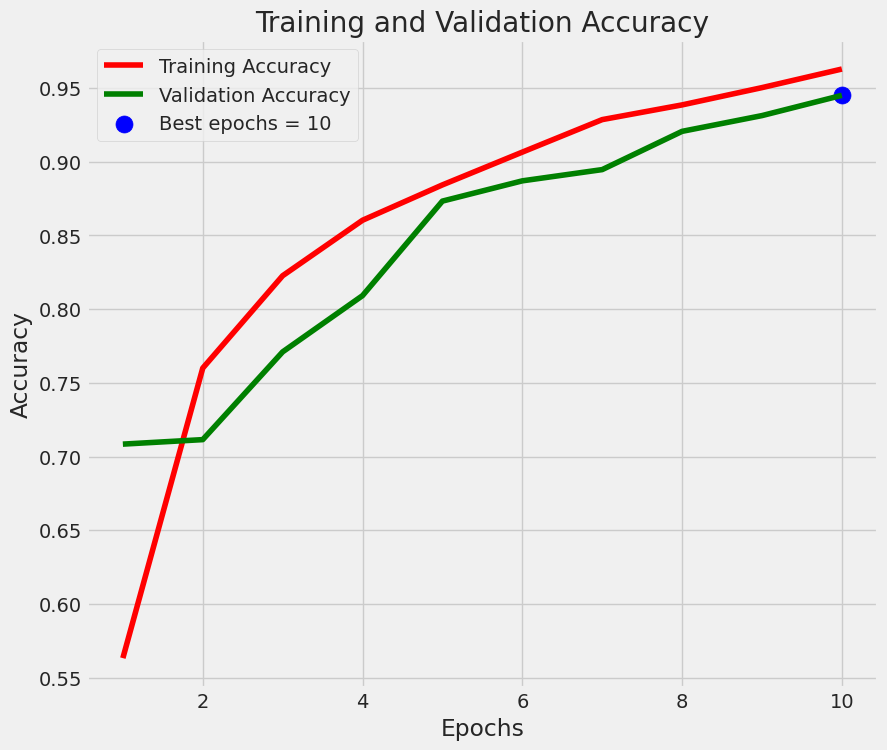

In [34]:
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

Generating learning curve for KNN (before tuning)...


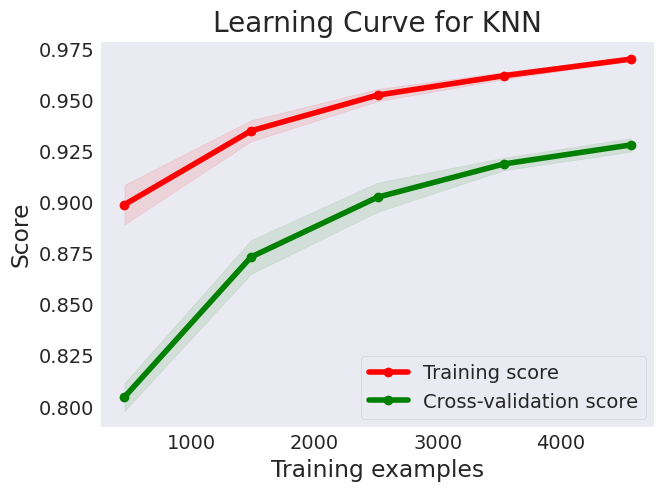

Generating learning curve for SVM (before tuning)...


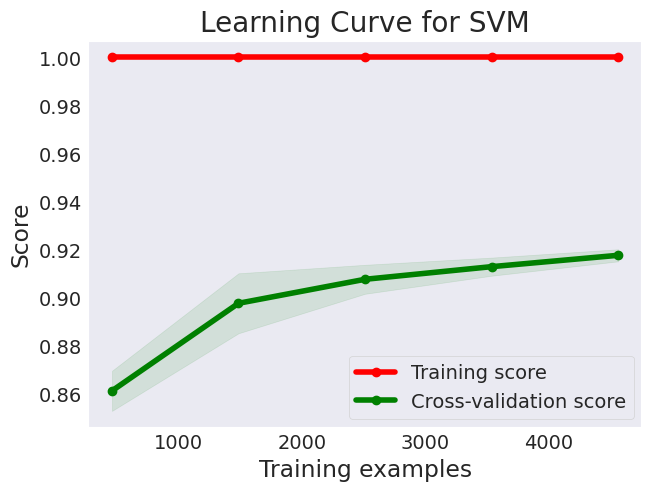

In [36]:

# import matplotlib.pyplot as plt
# import numpy as np

# Function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Learning Curve for KNN (before tuning)
print("Generating learning curve for KNN (before tuning)...")
knn = KNeighborsClassifier(n_neighbors=3)
plot_learning_curve(knn, "Learning Curve for KNN", train_features, train_labels_enc, cv=5)

# Learning Curve for SVM (before tuning)
print("Generating learning curve for SVM (before tuning)...")
svm = SVC(kernel='linear', probability=True)
plot_learning_curve(svm, "Learning Curve for SVM", train_features, train_labels_enc, cv=5)


Generating validation curve for KNN (before tuning)...


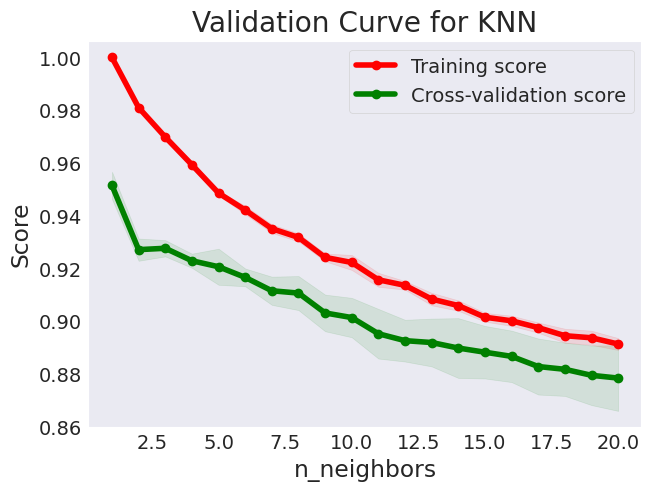

Generating validation curve for SVM (before tuning)...


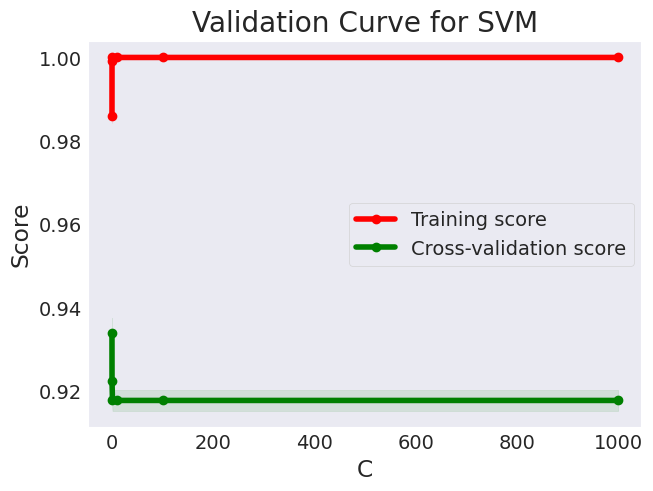

In [38]:
# Function to plot validation curve (model complexity)
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=None):
    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")

    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Model Complexity for KNN (before tuning) – varying k (number of neighbors)
print("Generating validation curve for KNN (before tuning)...")
k_range = np.arange(1, 21)
plot_validation_curve(KNeighborsClassifier(), "Validation Curve for KNN", train_features, train_labels_enc, param_name="n_neighbors", param_range=k_range, cv=5)

# Model Complexity for SVM (before tuning) – varying C parameter
print("Generating validation curve for SVM (before tuning)...")
C_range = np.logspace(-2, 3, 6)
plot_validation_curve(SVC(kernel='linear', probability=True), "Validation Curve for SVM", train_features, train_labels_enc, param_name="C", param_range=C_range, cv=5)


**Hyperparameter Tuning using Grid Search**

In [39]:
from sklearn.model_selection import GridSearchCV

# Grid Search for KNN
print("Performing Grid Search for KNN...")
knn_param_grid = {'n_neighbors': np.arange(1, 21)}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(train_features, train_labels_enc)
print(f"Best Parameters for KNN: {knn_grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy for KNN: {knn_grid_search.best_score_:.2f}")

# Grid Search for SVM
print("Performing Grid Search for SVM...")
svm_param_grid = {'C': np.logspace(-2, 3, 6), 'kernel': ['linear', 'rbf', 'poly']}
svm_grid_search = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(train_features, train_labels_enc)
print(f"Best Parameters for SVM: {svm_grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy for SVM: {svm_grid_search.best_score_:.2f}")


Performing Grid Search for KNN...
Best Parameters for KNN: {'n_neighbors': 1}
Best Cross-Validation Accuracy for KNN: 0.95
Performing Grid Search for SVM...
Best Parameters for SVM: {'C': 100.0, 'kernel': 'rbf'}
Best Cross-Validation Accuracy for SVM: 0.96


Generating learning curve for KNN (after tuning)...


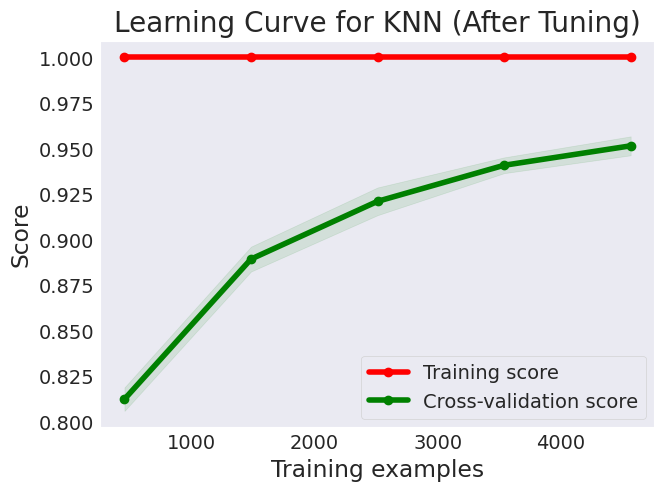

Generating learning curve for SVM (after tuning)...


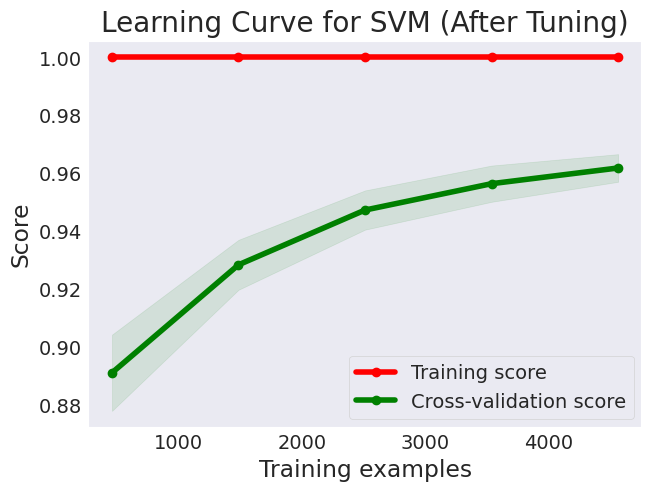

Generating validation curve for KNN (after tuning)...


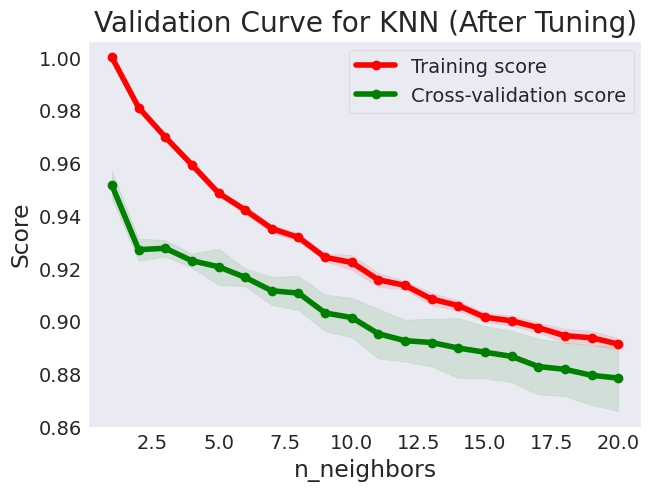

Generating validation curve for SVM (after tuning)...


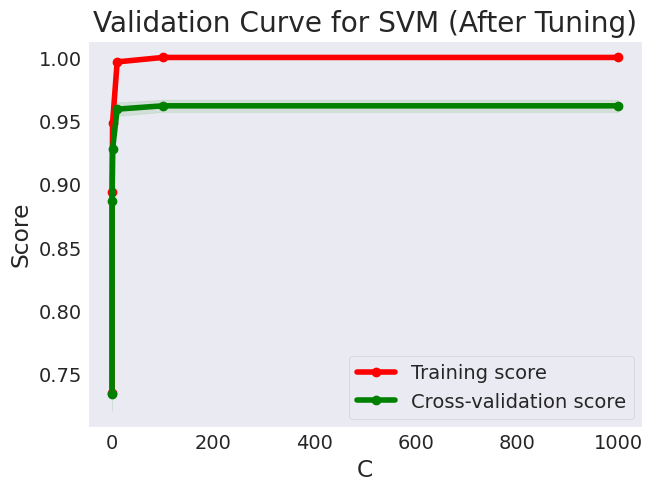

In [40]:
# Learning Curve for KNN (after tuning)
print("Generating learning curve for KNN (after tuning)...")
best_knn = KNeighborsClassifier(n_neighbors=knn_grid_search.best_params_['n_neighbors'])
plot_learning_curve(best_knn, "Learning Curve for KNN (After Tuning)", train_features, train_labels_enc, cv=5)

# Learning Curve for SVM (after tuning)
print("Generating learning curve for SVM (after tuning)...")
best_svm = SVC(kernel=svm_grid_search.best_params_['kernel'], C=svm_grid_search.best_params_['C'], probability=True)
plot_learning_curve(best_svm, "Learning Curve for SVM (After Tuning)", train_features, train_labels_enc, cv=5)

# Model Complexity for KNN (after tuning)
print("Generating validation curve for KNN (after tuning)...")
plot_validation_curve(best_knn, "Validation Curve for KNN (After Tuning)", train_features, train_labels_enc, param_name="n_neighbors", param_range=k_range, cv=5)

# Model Complexity for SVM (after tuning)
print("Generating validation curve for SVM (after tuning)...")
plot_validation_curve(best_svm, "Validation Curve for SVM (After Tuning)", train_features, train_labels_enc, param_name="C", param_range=C_range, cv=5)


Generating error graph for KNN (before tuning)...


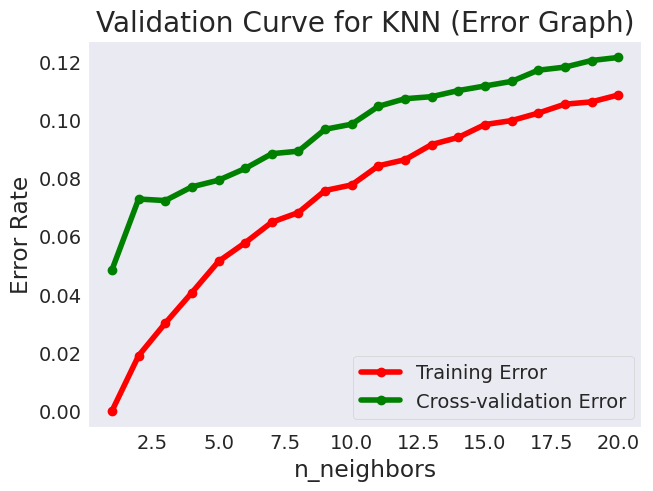

Generating error graph for SVM (before tuning)...


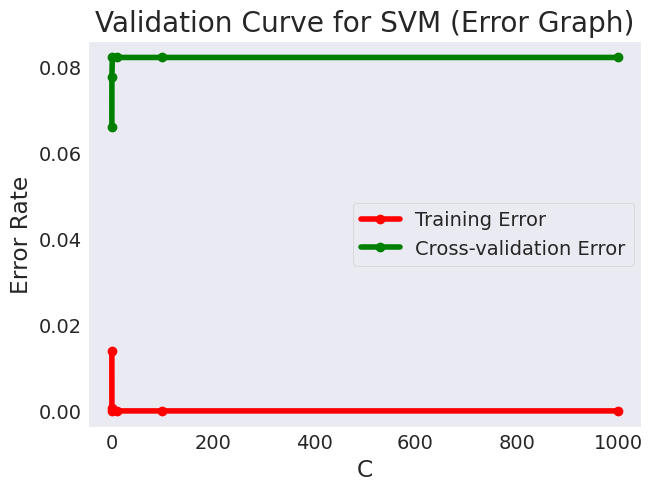

In [41]:
# Function to plot validation curve (error graph)
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=None):
    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Error Rate")  # This is error rate instead of score

    # Get the training and cross-validation scores
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    # Convert accuracy to error rate
    train_errors = 1 - np.mean(train_scores, axis=1)
    test_errors = 1 - np.mean(test_scores, axis=1)

    plt.grid()

    # Plot training error
    plt.plot(param_range, train_errors, 'o-', color="r", label="Training Error")

    # Plot cross-validation error
    plt.plot(param_range, test_errors, 'o-', color="g", label="Cross-validation Error")

    plt.legend(loc="best")
    plt.show()

# Before tuning: KNN Error Rate Graph – Varying 'k' (Number of Neighbors)
print("Generating error graph for KNN (before tuning)...")
k_range = np.arange(1, 21)
plot_validation_curve(KNeighborsClassifier(), "Validation Curve for KNN (Error Graph)", train_features, train_labels_enc, param_name="n_neighbors", param_range=k_range, cv=5)

# Before tuning: SVM Error Rate Graph – Varying 'C'
print("Generating error graph for SVM (before tuning)...")
C_range = np.logspace(-2, 3, 6)
plot_validation_curve(SVC(kernel='linear', probability=True), "Validation Curve for SVM (Error Graph)", train_features, train_labels_enc, param_name="C", param_range=C_range, cv=5)


In [ ]:
# After tuning: KNN Error Rate Graph – Varying 'k' (Use best params from Grid Search)
print("Generating error graph for KNN (after tuning)...")
# k=1 as the best value
plot_validation_curve(KNeighborsClassifier(n_neighbors=1), "Validation Curve for KNN (Error Graph) After Tuning", train_features, train_labels_enc, param_name="n_neighbors", param_range=k_range, cv=5)


print("Generating error graph for SVM (after tuning)...")
# C=100, kernel='rbf' as the best value
plot_validation_curve(SVC(kernel='rbf', C=100, probability=True), "Validation Curve for SVM (Error Graph) After Tuning", train_features, train_labels_enc, param_name="C", param_range=C_range, cv=5)


**Test Model Performance without Hyper-tuned Values**

In [43]:
# cnn model evaluation
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_gen)


# Knn model evaluation
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels_enc)
knn_pred = knn.predict(test_features)
knn_accuracy = accuracy_score(test_labels_enc, knn_pred)

# Evaluate KNN on the test set
# test_accuracy_knn = knn.score(test_features, test_labels_enc)
# print(f"KNN Model Test Set Accuracy: {test_accuracy_knn:.2f}")


# Finally, evaluate on the test set
# test_accuracy = svm.score(test_features, test_labels_enc)
# print(f"SVM Model Test Set Accuracy: {test_accuracy:.2f}")


# SVM model evaluation
svm = SVC(kernel='linear', probability=True)
svm.fit(train_features, train_labels_enc)
svm_pred = svm.predict(test_features)
svm_accuracy = accuracy_score(test_labels_enc, svm_pred)


41/41 [==============================] - 10s 232ms/step - loss: 0.1439 - accuracy: 0.9543


In [44]:
# print accuracies
print(f"Accuracy of CNN model: {cnn_accuracy:.2f}")
print(f"Accuracy of KNN model: {knn_accuracy:.2f}")
print(f"Accuracy of SVM model: {svm_accuracy:.2f}")

Accuracy of CNN model: 0.95
Accuracy of KNN model: 0.92
Accuracy of SVM model: 0.95


In [45]:
# plot accuracies for comparison
models = ['CNN', 'KNN', 'SVM']
accuracies = [cnn_accuracy, knn_accuracy, svm_accuracy]

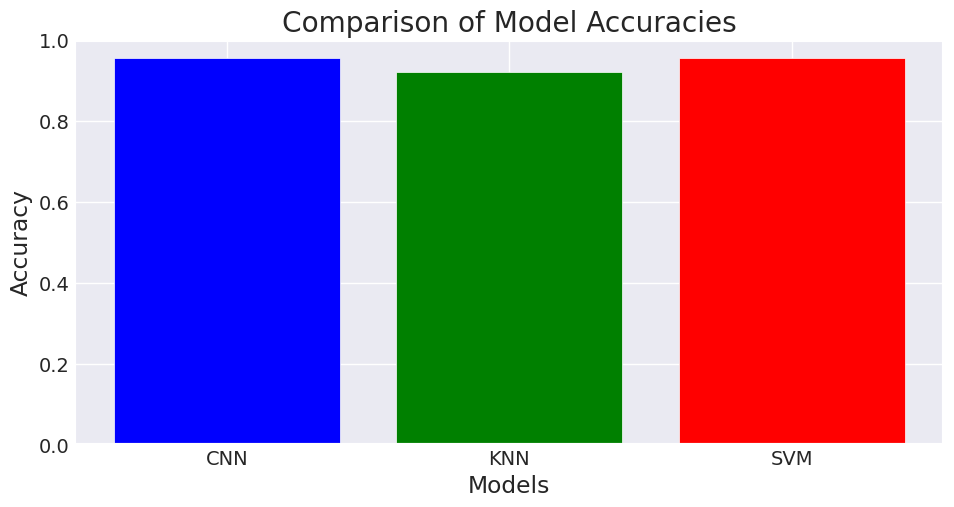

In [46]:
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()

In [48]:
from sklearn.metrics import classification_report

# Assuming test_features are the input features for the test set

# CNN Predictions
cnn_pred = cnn_model.predict(test_gen)
cnn_pred = cnn_pred.argmax(axis=1)  # Assuming you need to convert the output to class labels

# KNN Predictions
knn_pred = knn.predict(test_features)

# SVM Predictions
svm_pred = svm.predict(test_features)

# CNN Performance Report
print("CNN Model Performance:")
cnn_report = classification_report(test_labels_enc, cnn_pred, target_names=classes)
print(cnn_report)

# KNN Performance Report
print("KNN Model Performance:")
knn_report = classification_report(test_labels_enc, knn_pred, target_names=classes)
print(knn_report)

# SVM Performance Report
print("SVM Model Performance:")
svm_report = classification_report(test_labels_enc, svm_pred, target_names=classes)
print(svm_report)


41/41 [==============================] - 10s 230ms/step
CNN Model Performance:
              precision    recall  f1-score   support

      glioma       0.95      0.95      0.95       164
  meningioma       0.92      0.90      0.91       144
     notumor       0.98      0.99      0.98       201
   pituitary       0.97      0.97      0.97       147

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656

KNN Model Performance:
              precision    recall  f1-score   support

      glioma       0.90      0.90      0.90       164
  meningioma       0.86      0.83      0.84       144
     notumor       0.98      0.95      0.96       201
   pituitary       0.92      0.99      0.95       147

    accuracy                           0.92       656
   macro avg       0.92      0.92      0.92       656
weighted avg       0.92      0.92      0.92       656

SVM Model Performance:
     

Test Model Performance with Hypertuned values  ####TODO CNN

In [ ]:


# # Define the model with hypertuned parameters
# cnn_model = build_cnn_model(hyper_tuned_params)

# # Compile and train the model with hypertuned values
# cnn_model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# cnn_model.fit(train_gen, validation_data=val_gen, epochs=best_epochs, batch_size=best_batch_size)

# # Now evaluate the model on the test set
# cnn_loss, cnn_accuracy = cnn_model.evaluate(test_gen)
# print(f"CNN Model Test Set Accuracy: {cnn_accuracy:.2f}")


In [50]:
# Initialize KNN with hypertuned parameters
knn_h = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='manhattan')

# Fit the KNN model on the training data
knn_h.fit(train_features, train_labels_enc)

# Now evaluate the model on the test set
test_accuracy_knn = knn_h.score(test_features, test_labels_enc)
print(f"KNN Model Test Set Accuracy: {test_accuracy_knn:.2f}")


KNN Model Test Set Accuracy: 0.98


In [1]:
# Initialize the SVM with hypertuned parameters
svm_h = SVC(C=100, gamma='scale', kernel='rbf', degree=2, probability=True)

# Fit the SVM model on the training data
svm_h.fit(train_features, train_labels_enc)

# Now evaluate the model on the test set
test_accuracy = svm_h.score(test_features, test_labels_enc)
print(f"SVM Model Test Set Accuracy: {test_accuracy:.2f}")

NameError: name 'SVC' is not defined

In [ ]:
# print accuracies
print(f"Accuracy of CNN model: {cnn_accuracy:.2f}")
print(f"Accuracy of KNN model: {knn_accuracy:.2f}")
print(f"Accuracy of SVM model: {svm_accuracy:.2f}")